# Function 2 - Optimising Noisy Models  
This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.


In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

f1_inp = np.load("./../function_2/initial_inputs.npy")
f1_out = np.load("./../function_2/initial_outputs.npy")
f1_out


q1_inp = [0.125028, 0.706016]
q1_out = [0.11611401708527386]

q2_inp = [0.754418, 0.963375]
q2_out = [0.32222650104621703]


q3_inp = [0.757994, 0.737195]
q3_out = [0.31748997890343916]

q4_inp = [0.777398, 0.976694]
q4_out = [0.14609621294552494]


f1_inp = np.vstack((f1_inp, q1_inp, q2_inp, q3_inp))
f1_out = np.append(f1_out, [q1_out, q2_out,q3_out])
f1_inp, f1_out
# max(f1_out), np.mean(f1_out)

C:\Users\alerd\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(array([[0.66579958, 0.12396913],
        [0.87779099, 0.7786275 ],
        [0.14269907, 0.34900513],
        [0.84527543, 0.71112027],
        [0.45464714, 0.29045518],
        [0.57771284, 0.77197318],
        [0.43816606, 0.68501826],
        [0.34174959, 0.02869772],
        [0.33864816, 0.21386725],
        [0.70263656, 0.9265642 ],
        [0.125028  , 0.706016  ],
        [0.754418  , 0.963375  ],
        [0.757994  , 0.737195  ]]),
 array([ 0.53899612,  0.42058624, -0.06562362,  0.29399291,  0.21496451,
         0.02310555,  0.24461934,  0.03874902, -0.01385762,  0.61120522,
         0.11611402,  0.3222265 ,  0.31748998]))

In [2]:
max(f1_out) , min(f1_out), np.mean(f1_out)

(0.6112052157614438, -0.06562362443733738, 0.23558216617187336)

In [3]:
# toptop

# Exploratory Data Analysis (EDA) for Bayesian Optimization 

## **Objective**
The goal of the Exploratory Data Analysis (EDA) is to investigate the characteristics of the input-output relationships, data quality, and patterns that influence the performance of Bayesian Optimization. This analysis will help guide the selection of kernel parameters, acquisition functions, and input transformations to optimize model performance and robustness.


1. **Data Quality**  
   - Identify outliers via z-scores or IQR (ensures kernel parameters aren’t distorted by extreme values, example an outlier can create unrealistic length scales or amplitude of kernel parameters). Consider removing or transforming them.
   - Check for missing/null values and decide on imputation or removal (helps avoid skewing the GP’s fit). Remove duplicates if there is any  (prevents overemphasis on certain points).  


2. **Data Distribution**  
   - Plot histograms to spot skewness (so we can apply tansfromation of input and output), to address heteroscedascity.  
   - Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000), larger ranges dominate distance calculations, distorting kernel behavior).
    - Check, variance, skewnes which can be needed in further steps

3. **Input-Output Relationships**  
   - Use correlation matrices to find strong or weak drivers of the target (remove features that are not relevant and add noise to the data).  
   - Visualize scatter/surface plots (reveals potential nonlinearity or interactions for better GP modeling).
   

6. **Noise and Uncertainty**  
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).  
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - Consider removing  as the step above if it removes the noise 
     - If skewness is low but variance is high in RESIDUALS, focus on adding a noise term to the kernel, reults from step 2
7. **Feature Engineering**  
   - Apply dimensionality reduction (e.g., PCA) if many correlated features (simplifies model, reduces noise).  
   - Assess feature importance (e.g., SHAP) to prioritize critical inputs (focuses GP where it matters).
   

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput
   - Lengthscle check variance on input
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
   - Select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Match kernel amplitude to output variance (captures overall scale of the data).  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 

8. **Acquisition Function Behavior**  
   - Monitor exploration-exploitation trade-offs (e.g., EI, PI, UCB) to ensure effective sampling (speeds convergence).  
   - Adjust parameters like \(\beta\) or \(\xi\) to fine-tune that balance (enhances optimization efficiency).


9. **Iterative Refinement**  
   - Revisit EDA after initial Bayesian runs (refine kernel hyperparameters, acquisition settings).  
   - Visualize updated surfaces and residuals (validates improvements and ensures robust GP performance).


In [4]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

pd_inp.isnull().sum()  # No null on input 0 , 1 are the columns 
pd_out.isnull().sum()  # No null on output
sum(pd_inp.duplicated())   # 0 duplicates
sum(pd_out.duplicated())   # 0 duplicates

0

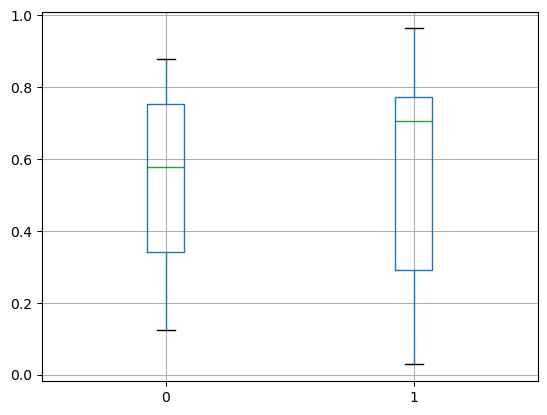

In [5]:
## Checking for outliers

pd_inp.boxplot() # No outliers second feature more spread, need to standarise features, so it fits kernel, if Matern, RBA
plt.show()

<Axes: >

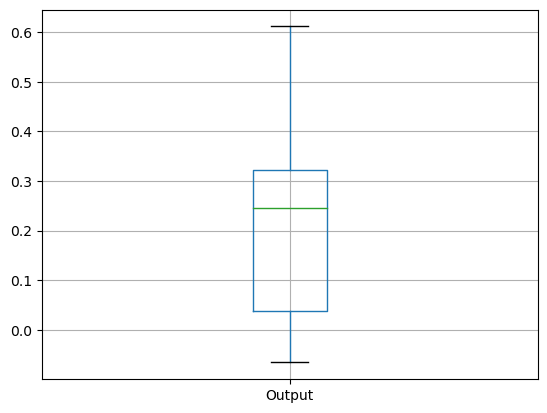

In [6]:
pd_out.boxplot() # No outliers 

## Distribution 

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

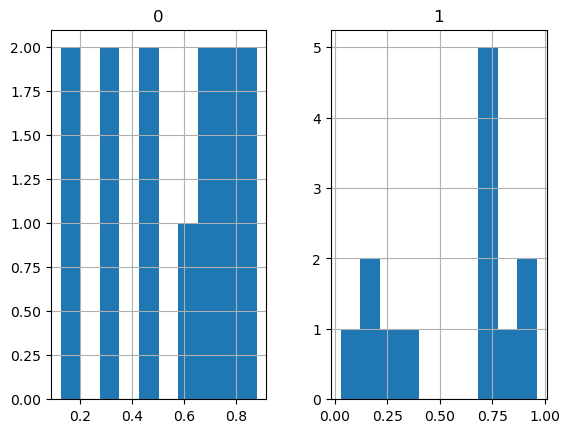

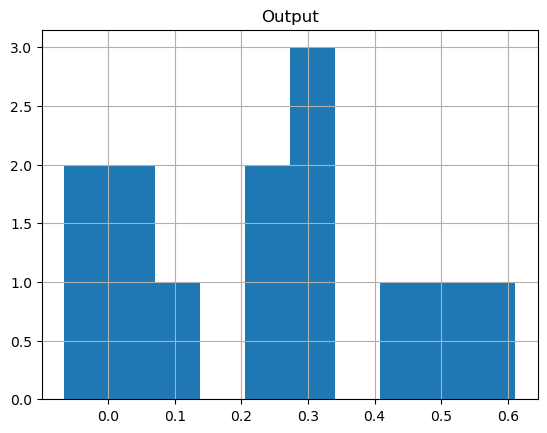

In [7]:
pd_inp.hist(), pd_out.hist()

In [8]:
skew(f1_inp),skew(f1_out)
np.var(f1_inp),np.var(f1_out)



(0.07558032011089066, 0.04127856063444564)

# Input/Output Relationship Analysis 

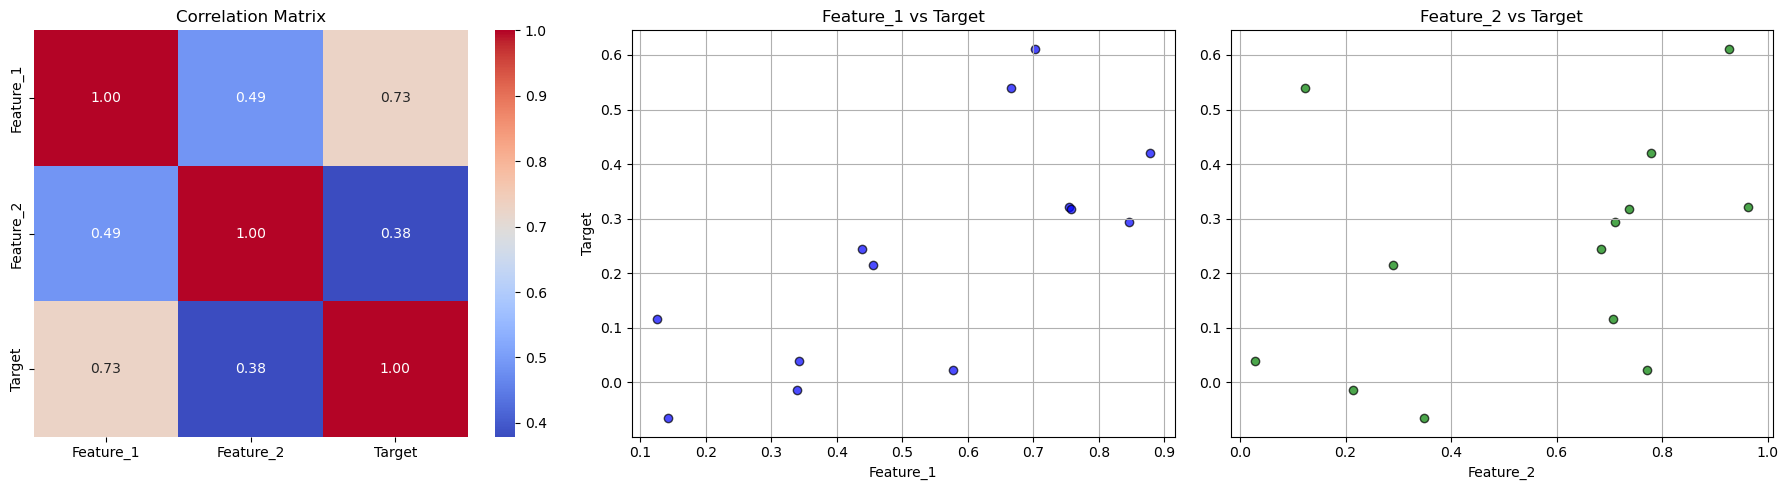

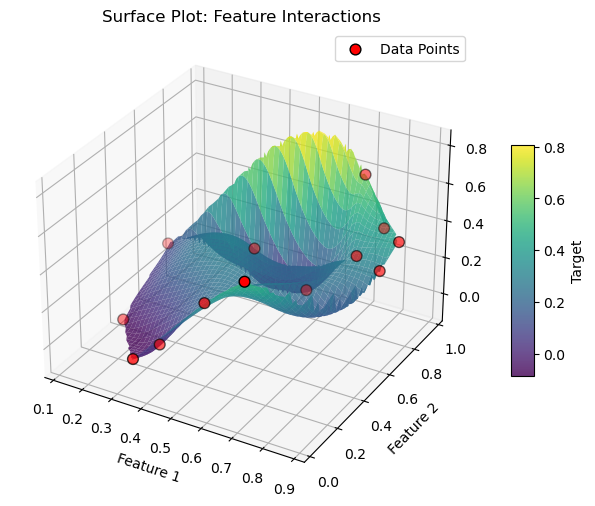

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

# Ensure f1_out is 1D
f1_out = f1_out.ravel()

# Create a figure for the inline plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# **1. Correlation Matrix**
# Convert f1_inp and f1_out to a single NumPy array for correlation
data = np.hstack((f1_inp, f1_out.reshape(-1, 1)))

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(data.T)

# Plot correlation heatmap
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    xticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    yticklabels=[f"Feature_{i+1}" for i in range(f1_inp.shape[1])] + ["Target"],
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix")

# **2. Scatter Plot: Feature 1 vs Target**
axes[1].scatter(f1_inp[:, 0], f1_out, color="blue", alpha=0.7, edgecolor="k")
axes[1].set_xlabel("Feature_1")
axes[1].set_ylabel("Target")
axes[1].set_title("Feature_1 vs Target")
axes[1].grid(True)

# **3. Scatter Plot: Feature 2 vs Target (if exists)**
if f1_inp.shape[1] > 1:
    axes[2].scatter(f1_inp[:, 1], f1_out, color="green", alpha=0.7, edgecolor="k")
    axes[2].set_xlabel("Feature_2")
#     axes[2].set_ylabel("Target")
    axes[2].set_title("Feature_2 vs Target")
    axes[2].grid(True)
else:
    axes[2].axis("off")
    axes[2].set_title("Feature_2 vs Target (Not Available)")

plt.tight_layout()
plt.show()





# ---------------**3D Surface Plot (Separate Block for Feature Interaction)**
#if f1_inp.shape[1] == 2:  # Ensure input is 2D
x, y = f1_inp[:, 0], f1_inp[:, 1]
z = f1_out

# Create grid points for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Z values for the grid
grid_z = griddata(
    (x, y), z, 
    (grid_x, grid_y), 
    method="cubic"
)

  # This visual can be good for function 1 to identify the two local minimas   
#     # Handle potential issues with NaN values in grid_z
#     if np.isnan(grid_z).any():
#         grid_z = np.nan_to_num(grid_z)  # Replace NaNs with zeros or interpolated values

# Plotting the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, 
    cmap="viridis", 
    edgecolor="none", 
    alpha=0.8
)
# Scatter points (data points)
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
ax.legend(loc="best")  # Add legend for clarity

cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Target")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
#     ax.set_zlabel("Target")
plt.title("Surface Plot: Feature Interactions")
plt.show()
# else:
#     print("Surface plot requires exactly 2 features in the input data.")
    
    
# The red on the 3d surface plot its just to make the plot easier to see


### Conclusion about input/ouput relationship
- There is a stornger correlence between feature One and the output
- 2 LOCAL Optimas




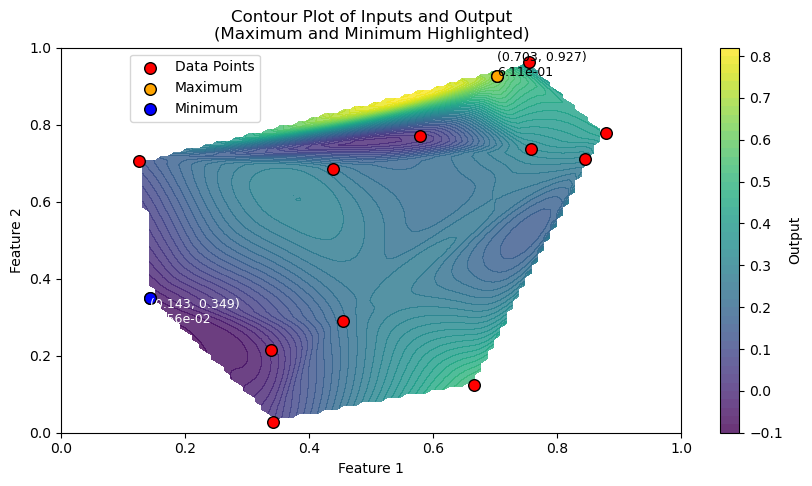

Max: 6.11e-01 at (0.7026, 0.9266)
Min: -6.56e-02 at (0.1427, 0.3490)


In [10]:

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Identify max/min points
max_idx, min_idx = np.argmax(z), np.argmin(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', edgecolor='black', s=70, label="Data Points")
plt.scatter([max_x], [max_y], color='orange', edgecolor='black', s=70, label="Maximum")
plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}", fontsize=9, color='black')
plt.scatter([min_x], [min_y], color='blue', edgecolor='black', s=70, label="Minimum")
plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}", fontsize=9, color='white',
         ha='left', va='top')
plt.xlabel("Feature 1"), plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Output\n(Maximum and Minimum Highlighted)")
plt.legend()
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))

plt.show()

print(f"Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
print(f"Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")

- From above we could see that Feature 1 was more correlated with output variable, so we might exepect that to grow on the result of acquistion function

# Analysing Noise and Uncertianty

Noise and Uncertainty
     
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2 
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2
    - Test after you have built the surrogate model, if there are future that just add noise and affect predictions 
- Aim: Follow a data-driven strategy, based on the parameters of the data, to set the inital parameter of the kernel

In [11]:
# Analysing skewnes and variance 




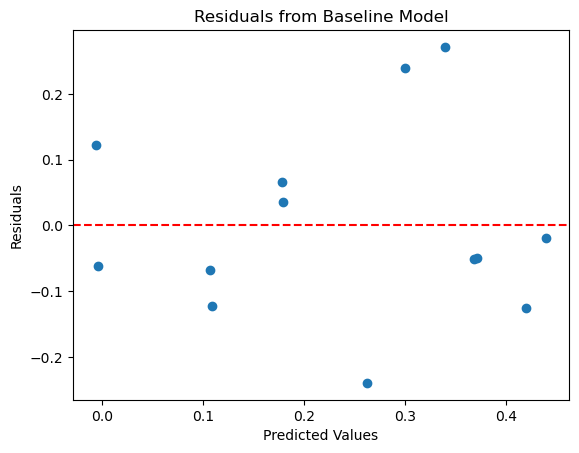

Residual Variance: 0.021
Residual Mean: 0.000


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example Data (replace with your data)
x = f1_inp
z = f1_out  # Observed target

# Fit a baseline model (Linear Regression)
model = LinearRegression()
model.fit(x, z)
z_pred = model.predict(x)  # Predictions from the baseline model

# Residuals
residuals = z - z_pred

# Plot Residuals
plt.scatter(z_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals from Baseline Model")
plt.show()

# Print Residual Statistics
print(f"Residual Variance: {np.var(residuals, ddof=1):.3f}")
print(f"Residual Mean: {np.mean(residuals):.3f}")


In [13]:
# Signal Variance (Variance of Predictions)
signal_variance = np.var(z_pred, ddof=1)

# Residual Variance (Variance of Noise)
residual_variance = np.var(residuals, ddof=1)
residual_skewness = skew(residuals)
# Signal-to-Noise Ratio (SNR)
snr = signal_variance / residual_variance

# Display Metrics
print(f"Signal Variance: {signal_variance:.3f}")
print(f"Residual Variance (Noise): {residual_variance:.3f}")
print(f"Residual Skewnes : {residual_skewness:.3f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.3f}")


Signal Variance: 0.024
Residual Variance (Noise): 0.021
Residual Skewnes : 0.494
Signal-to-Noise Ratio (SNR): 1.119



### Conclusion
- There is some noise in the data, as we have some unexplained variance,
- WhiteKernel noise to be added 

- No PCA Needed as we have only 2 features


# Kernel Parameters Analysis

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput will match kernel amplitude to output variance (captures overall scale of the data). 
   - Lengthscle check variance on input, will select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 


In [14]:
output_variance = np.var(f1_out, ddof=1)
amplitude_init = np.sqrt(output_variance)
amplitude_init

input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
length_scale_init

# Bounds will always be the bounds of the input variable, IMPORTANT TO CHECK FOR OUTLIERS
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension
amplitude_init,length_scale_init,  extended_min_bounds, extended_max_bounds

(0.21146735135078443,
 array([0.25364691, 0.31495773]),
 array([ 0.0497517 , -0.06477001]),
 array([0.95306729, 1.05684273]))

- Start with the above Amplitude but let the optimizer refine it during training
- Start with the above Lenfthscale but let the optimizer refine it during training

## ****NOTE**** After the above analysis I will skip the INPUT / OUPUT transformation, as the relationship between the features and output seems monotonic and does have variablity 


# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



(array([ 0.53899612,  0.42058624, -0.06562362,  0.29399291,  0.21496451,
         0.02310555,  0.24461934,  0.03874902, -0.01385762,  0.61120522,
         0.11611402,  0.3222265 ,  0.31748998]),
 array([[ 1.41419203],
        [ 0.93052745],
        [-1.61989655],
        [ 0.3651071 ],
        [-0.0175919 ],
        [-1.06524144],
        [ 0.12894474],
        [-0.9725155 ],
        [-1.29027607],
        [ 1.69064301],
        [-0.53415543],
        [ 0.49601032],
        [ 0.47425224]]))

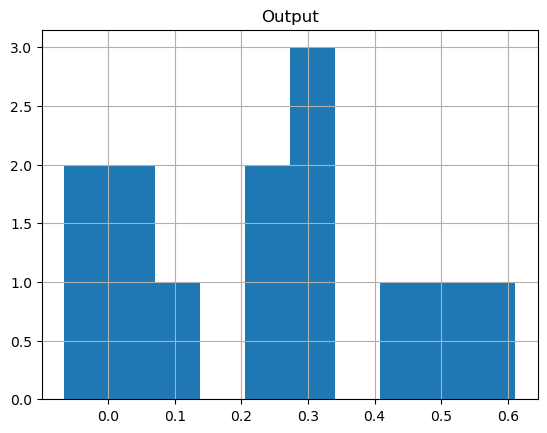

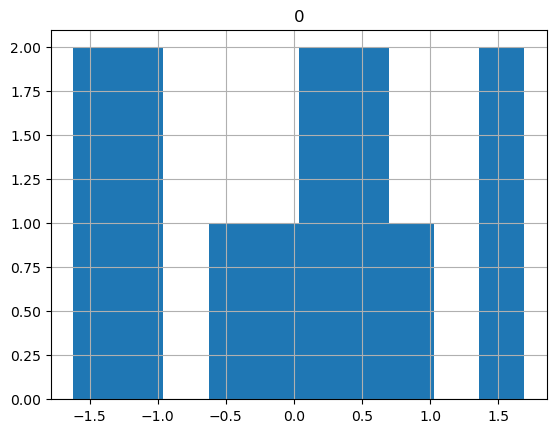

In [15]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

# Assuming f1_out is a NumPy array or a pandas Series
f1_out_transformed = PowerTransformer(method='yeo-johnson').fit_transform(f1_out.reshape(-1, 1))
out_trans = pd.DataFrame(f1_out_transformed)
pd_out.hist(), out_trans.hist()

f1_out, f1_out_transformed

# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [19]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
np.std(f1_inp_normalized), np.std(f1_inp)
skew(f1_inp_normalized), skew(f1_inp)
f1_inp_normalized

array([[0.71838226, 0.10192974],
       [1.        , 0.80234087],
       [0.02347495, 0.34269305],
       [0.95680505, 0.73011569],
       [0.43787905, 0.28005116],
       [0.60136438, 0.7952215 ],
       [0.41598493, 0.70218946],
       [0.2879015 , 0.        ],
       [0.28378143, 0.19811065],
       [0.76731795, 0.96061656],
       [0.        , 0.7246547 ],
       [0.83610646, 1.        ],
       [0.84085696, 0.75801273]])

In [57]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 100
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


C:\Users\alerd\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\alerd\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
Genetic Algorithm Generations:   0%|                                                           | 0/100 [00:00<?, ?it/s]C:\Users\alerd\AppData\Local\Temp\ipykernel_20800\537062682.py:10: RuntimeWarning: invalid value encountered in power
  return 1 - (1 - X_clipped ** a) ** b
Genetic Algorithm Generations: 100%|█████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.99it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 0.307298
b = 0.395145
Combined Score (Variance + Skewness) = 0.083430
Final Variance: 0.069354
Final Skewness: 0.014076


(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object))

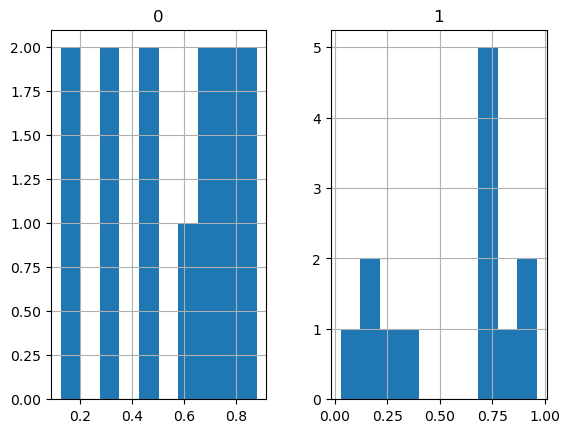

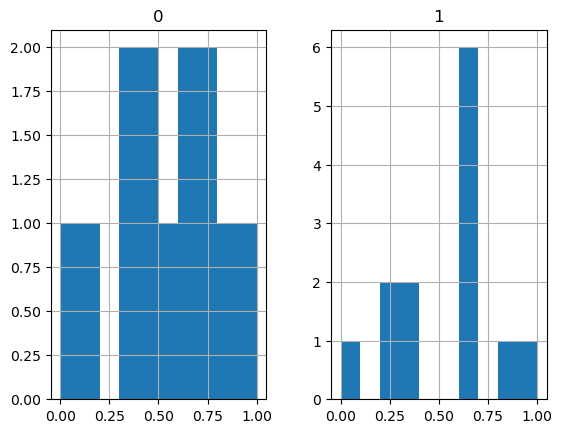

In [20]:
from scipy.stats import skew
# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b


# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.411047, b=0.468162)

pd_inp_transformed = pd.DataFrame(f1_inp_warped)

pd_inp.hist(), pd_inp_transformed.hist()


# ***************************** Gaussian Process****************************


# Testing Diffrent Kernels 

In [ ]:
# f1_inp = f1_inp_warped
# f1_out  = f1_out_transformed
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, ExpSineSquared

# Replace with your actual dataset
X = f1_inp_warped  # Input features
y = f1_out_transformed  # Output/target

length_scales = np.linspace(0.05, 1.5, 100)  # Narrower range around observed data
bounds_list = [(0.05, bound) for bound in np.linspace(1.0, 1.1, 20)]  # Slightly extended bounds

# Storage for results
results = []

# Kernel options
kernels = ["Matern_nu_1.5", "Matern_nu_2.5", "RationalQuadratic", "ExpSineSquared"]

for kernel_name in kernels:
    for length_scale in length_scales:
        for bounds in bounds_list:
            # Create kernel based on the current configuration
            if kernel_name == "Matern_nu_1.5":
                kernel = Matern(length_scale=length_scale, nu=1.5, length_scale_bounds=bounds)
            elif kernel_name == "Matern_nu_2.5":
                kernel = Matern(length_scale=length_scale, nu=2.5, length_scale_bounds=bounds)
            elif kernel_name == "RationalQuadratic":
                kernel = RationalQuadratic(
                    length_scale=length_scale,
                    alpha=1.0,
                    length_scale_bounds=bounds,
                    alpha_bounds=(1e-2, 100),
                )
            elif kernel_name == "ExpSineSquared":
                kernel = ExpSineSquared(
                    length_scale=length_scale,
                    periodicity=1.0,  # Default periodicity, you can vary this too
                    length_scale_bounds=bounds,
                    periodicity_bounds=(1e-2, 10),
                )
            
            # Train Gaussian Process with the current kernel
            try:
                gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
                gp.fit(X, y)

                # Calculate Log Marginal Likelihood (LML)
                lml = gp.log_marginal_likelihood()

                # Store results
                results.append({
                    "Kernel": kernel_name,
                    "Length Scale": length_scale,
                    "Bounds": bounds,
                    "Kernel Parameters": str(kernel),
                    "LML": lml,
                })
            except Exception as e:
                # Log any errors encountered
                results.append({
                    "Kernel": kernel_name,
                    "Length Scale": length_scale,
                    "Bounds": bounds,
                    "Kernel Parameters": str(kernel),
                    "LML": None,
                    "Error": str(e),
                })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort results by LML (Log Marginal Likelihood) for better kernels
results_df = results_df.sort_values(by="LML", ascending=False, na_position='last')

# Display the sorted results
results_df.head(10)


In [192]:
# first_result = results_df.copy()f1_inp,f1_out
#second_result = results_df.copy() f1_inp_warped,f1_out_transformed
#third_result = results_df.copy()f1_inp,f1_out_transformed


first_result.head(1) # This has gotten the best result so far so I am thinking not to transform since the lML is priority in this usecase

,Kernel,Length Scale,Bounds,Kernel Parameters,LML
4386,RationalQuadratic,0.328283,"(0.05, 1.0315789473684212)","RationalQuadratic(alpha=1, length_scale=0.328)",-0.632252


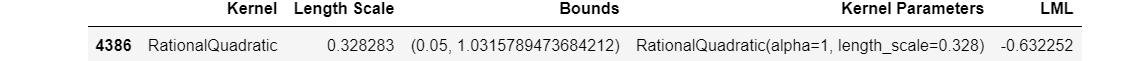
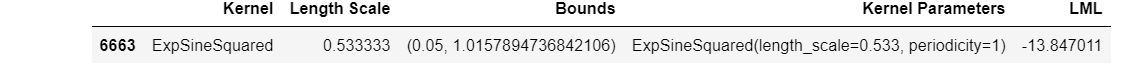
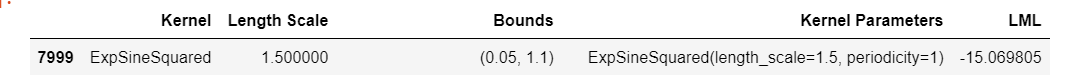


### Rational Quadritic Kernel is having the best score so far
- The good news is with this kernel we do not need to standarise the data as per the below instruction 
- Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000),

In [109]:
results_df_1.head(1) # Same result as above 

,Alpha,Alpha Bounds,Noise Level,Noise Level Bounds,Kernel Parameters,LML
1210,100.0,"(1e-06, 56.23413251903491)",0.000316,"(1e-09, 1e-09)","RationalQuadratic(alpha=100, length_scale=0.23...",-1.031545


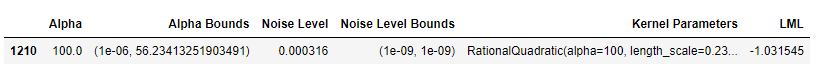

In [107]:
# Drop non-numeric columns automatically
results_df_1_cleaned = results_df_1.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = results_df_1_cleaned.corr()

# Display the correlation matrix
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,Alpha,Noise Level,LML
Alpha,1.000000e+00,-1.631302e-17,-4.022759e-10
Noise Level,-1.631302e-17,1.000000e+00,-5.076171e-08
LML,-4.022759e-10,-5.076171e-08,1.000000e+00


# Surprisingly noise levels are not  imapcting LML on kernel
- I will try input/output tranformation

In [49]:
import numpy as np
import warnings
import random
from tqdm import tqdm
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RationalQuadratic, WhiteKernel
from numpy.linalg import LinAlgError

# Replace with your actual dataset
X = f1_inp  # Input features
y = f1_out  # Output/target

TARGET_LML = 50   # Early-stopping threshold
N_TRIES = 100000     # Number of random parameter attempts
BEST_LML = -np.inf
BEST_GP = None
BEST_PARAMS = None

# Suppress boundary warnings for cleaner output
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # Use tqdm for a loading bar
    with tqdm(total=N_TRIES, desc="Random Search: RationalQuadratic + ConstantKernel") as pbar:
        for i in range(N_TRIES):
            # Randomly sample hyperparameters
            constant_value = 10 ** np.random.uniform(-1, 3)  # ~ 0.1 to 1000
            length_scale = 10 ** np.random.uniform(-2, 1)  # ~ 0.01 to 10
            alpha = 10 ** np.random.uniform(-6, 1)  # ~ 1e-6 to 10
            noise_level = 10 ** np.random.uniform(-10, -3)  # ~ 1e-10 to 1e-3

            # Define the kernel with randomized parameters
            kernel = (
                C(constant_value, (1e-2, 1000))  # Randomized constant multiplier
                * RationalQuadratic(
                    length_scale=length_scale,
                    alpha=alpha,
                    length_scale_bounds=(0.01, 10),
                    alpha_bounds=(1e-6, 10)
                )
            ) + WhiteKernel(
                noise_level=noise_level,
                noise_level_bounds=(1e-10, 1e-3)
            )

            # Create Gaussian Process Regressor
            gp = GaussianProcessRegressor(
                kernel=kernel,
                n_restarts_optimizer=5,
                random_state=random.randint(1, 9999)
            )

            # Try fitting the GP
            try:
                gp.fit(X, y)
            except LinAlgError:
                pbar.update(1)
                continue

            # Compute log marginal likelihood (LML)
            lml = gp.log_marginal_likelihood()
            if lml > BEST_LML:
                BEST_LML = lml
                BEST_GP = gp
                BEST_PARAMS = (constant_value, length_scale, alpha, noise_level)
                print(f"New Best LML: {BEST_LML:.6f} at Iteration {i}/{N_TRIES}")

            # Early stopping
            if BEST_LML > TARGET_LML:
                print(f"\nFound LML={BEST_LML:.6f} > {TARGET_LML}. Stopping early.")
                break

            pbar.update(1)

# Display final results
print("\nSearch Complete!")
print(f"Best LML: {BEST_LML:.6f}")
if BEST_PARAMS is not None:
    print("Best parameter combination:")
    print(f"  Constant Value: {BEST_PARAMS[0]}")
    print(f"  Length Scale  : {BEST_PARAMS[1]}")
    print(f"  Alpha         : {BEST_PARAMS[2]}")
    print(f"  Noise Level   : {BEST_PARAMS[3]}")
    print("\nBest GP Kernel:\n", BEST_GP.kernel_)
else:
    print("No valid parameters found.")


Random Search: RationalQuadratic + ConstantKernel:  42%|████████▍           | 42191/100000 [3:21:05<4:35:32,  3.50it/s]


KeyboardInterrupt: 

In [50]:
print("\nBest result so far:")
print(f"Best LML: {BEST_LML:.6f}")
if BEST_PARAMS is not None:
    print("Best parameter combination:")
    print(f"  Constant Value: {BEST_PARAMS[0]}")
    print(f"  Length Scale  : {BEST_PARAMS[1]}")
    print(f"  Alpha         : {BEST_PARAMS[2]}")
    print(f"  Noise Level   : {BEST_PARAMS[3]}")
    print("\nBest GP Kernel:\n", BEST_GP.kernel_)
else:
    print("No valid parameters found.")
    
    

# Best result so far:
# Best LML: 0.213031
# Best parameter combination:
#   Constant Value: 0.1017640746478062
#   Length Scale  : 1.4398847242432051
#   Alpha         : 0.0006446794322603817
#   Noise Level   : 6.845797612820619e-05

# Best GP Kernel:
#  0.34**2 * RationalQuadratic(alpha=0.176, length_scale=0.128) + WhiteKernel(noise_level=1e-10)



Best result so far:
Best LML: 0.213031
Best parameter combination:
  Constant Value: 0.1017640746478062
  Length Scale  : 1.4398847242432051
  Alpha         : 0.0006446794322603817
  Noise Level   : 6.845797612820619e-05

Best GP Kernel:
 0.34**2 * RationalQuadratic(alpha=0.176, length_scale=0.128) + WhiteKernel(noise_level=1e-10)


In [132]:
# No transformation for this function 
# For the second query I have decided to transform 

In [21]:
x_final = f1_inp_warped
y_final  = f1_out_transformed

# - Final Kernel 

In [22]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
# Define the kernel with parameters directly


test_kernel = (
    C(1.0) * (Matern([0.5, 0.2], nu=1.5) + RBF([0.5, 0.2], length_scale_bounds=(1e-8, 10)))
            + WhiteKernel(6.845797612820619e-05, noise_level_bounds=(1e-8, 1))
)

# Create and train the Gaussian Process model
gp = GaussianProcessRegressor(kernel=test_kernel, n_restarts_optimizer=5, random_state=42)

# Fit the model (replace X and y with your actual data)
gp.fit(x_final, y_final)

# Calculate Log Marginal Likelihood (LML)
lml = gp.log_marginal_likelihood()

lml


C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


-16.843147563544015

In [23]:
# Function to determine dynamic bounds
def get_dynamic_bounds(x_final):
    bounds = []
    for i in range(x_final.shape[1]):  
        feature_min, feature_max = x_final[:, i].min(), x_final[:, i].max()

        # Check if the feature is already in [0,1]
        if np.all((x_final[:, i] >= 0) & (x_final[:, i] <= 1)):
            bounds.append((0, 1))  # Keep [0,1]
        else:
            bounds.append((feature_min, feature_max))  # Use actual range

    return bounds

# Get dynamic bounds for x_final
bounds = get_dynamic_bounds(f1_inp)
print("Dynamic Bounds:", bounds)


Dynamic Bounds: [(0, 1), (0, 1)]


# Implementation 

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Next point to evaluate: [0.73405915 0.85413915]


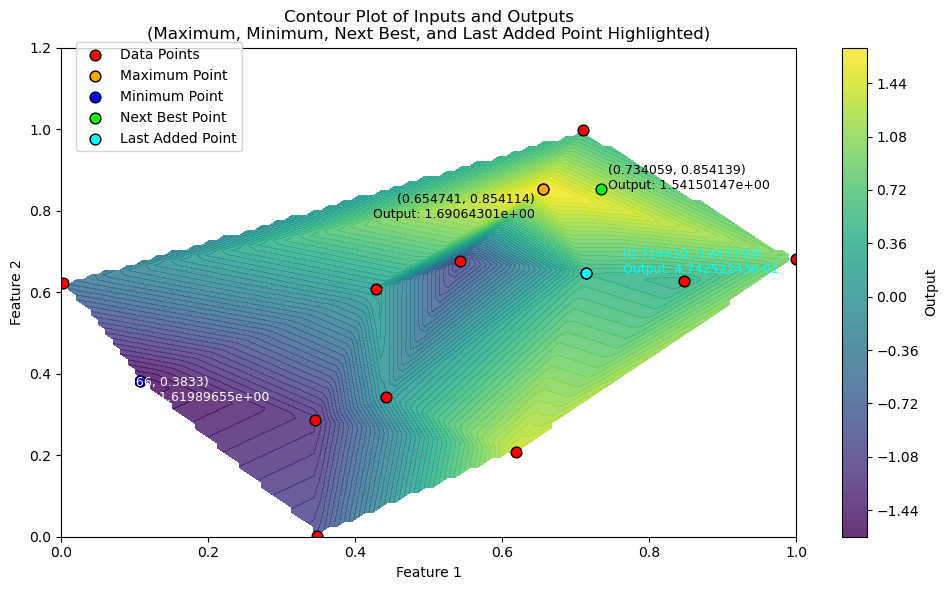

Maximum Value: 1.69064301e+00 at (x1=0.6547, x2=0.854114)
Minimum Value: -1.61989655e+00 at (x1=0.1066, x2=0.383322)
Next Best Point (MACE): 1.54150147e+00 at (x1=0.734059, x2=0.854139)
Last Added Point: 4.74252243e-01 at (x1=0.714430, x2=0.647790)


In [24]:

import numpy as np
from scipy.stats import norm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from scipy.interpolate import griddata
from pymoo.core.problem import Problem
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RationalQuadratic, WhiteKernel

class HEBOOptimizer:
    def __init__(self, bounds, initial_X=None, initial_y=None,
                 beta=2.5, xi=1.0, epsilon=0.1, random_state=None, noise_factor=0.01):

        self.bounds = np.array(bounds)
        self.dim = len(bounds)
        self.beta = beta
        self.xi = xi
        self.epsilon = epsilon
        self.rng = np.random.RandomState(random_state)
        
        # Initialize data storage
        self.X = initial_X 
        self.y = initial_y 
        noise_level = max(noise_factor * np.var(x_final), 1e-8)
        # Configure GP kernel
        self.kernel = (
            C(1.0) * (Matern([0.5, 0.2], nu=1.5) + RBF([0.5, 0.2], length_scale_bounds=(1e-8, 10)))
                    + WhiteKernel(6.845797612820619e-05, noise_level_bounds=(1e-8, 1))
        )
        
    def _fit_gp(self, kernel=None):
        if kernel is None:
            kernel = self.kernel  # n_restarts_optimizer=10,
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False,
            random_state=self.rng
        )
        gp.fit(self.X, self.y)
        return gp



    def _stochastic_mean(self, mu, noise_var):
        """HEBO's noise-adjusted mean"""
        return mu + self.xi * noise_var

    def _mace_optimization(self, gp):
        """Core MACE multi-acquisition optimization"""
        class MACEProblem(Problem):
            def __init__(self, gp, bounds, best, beta, xi):
                super().__init__(n_var=len(bounds), n_obj=3,
                                xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
                self.gp = gp
                self.best = best
                self.beta = beta
                self.xi = xi

            def _evaluate(self, X, out, *args, **kwargs):
                mu, sigma = self.gp.predict(X, return_std=True)
                
                # Correct way to access noise level
                noise_var = self.gp.kernel_.get_params().get('k2__noise_level', 1e-9)
                
                mu_adj = mu + self.xi * noise_var  # HEBO's stochastic mean
                
                # Calculate acquisition functions
                sigma = np.maximum(sigma, 1e-9)  # Avoid divide by zero
                Z = (mu_adj - self.best) / sigma
                
                ei = (mu_adj - self.best) * norm.cdf(Z) + sigma * norm.pdf(Z)
                pi = norm.cdf(Z)
                ucb = mu_adj + self.beta * sigma
                
                # Minimize [-EI, -PI, UCB]
                out["F"] = np.column_stack([-ei, -pi, ucb])

        if len(self.y) == 0:
            return self._random_sample()
        
        problem = MACEProblem(gp, self.bounds, np.max(self.y), self.beta, self.xi)
        algorithm = NSGA2(pop_size=50, eliminate_duplicates=True)
        res = minimize(problem, algorithm, ("n_gen", 100), verbose=False)
        
        if res.X.size == 0:
            return self._random_sample()
        
        # Select best candidate from Pareto front (maximize EI)
        return res.X[np.argmax(-res.F[:, 0])]

    def _random_sample(self):
        """Generate random sample within bounds"""
        return np.array([self.rng.uniform(low, high) for (low, high) in self.bounds]).reshape(1, -1)

    def suggest_next_point(self):
        """Returns next candidate point for evaluation (maximization)"""
        # Epsilon-greedy exploration
        if self.rng.rand() < self.epsilon:
            return self._random_sample()
        # Fit GP with current data
        gp = self._fit_gp()
        # Run MACE optimization
        candidate = self._mace_optimization(gp)
        
        # Ensure candidate is within bounds
        return np.clip(candidate, self.bounds[:, 0], self.bounds[:, 1])

    def update_data(self, X_new, y_new):
        """Update observed data with new point(s)"""
        self.X = np.vstack([self.X, np.atleast_2d(X_new)])
        self.y = np.concatenate([self.y, np.atleast_1d(y_new)])
    

## Change this depending if the input is normalised/tranformed or not
def get_dynamic_bounds(x_final):
    return [(0, 1) if np.all((x >= 0) & (x <= 1)) else (x.min(), x.max()) for x in x_final.T]

bounds = get_dynamic_bounds(x_final)


hebo = HEBOOptimizer(
    bounds=bounds,
    initial_X=x_final,
    initial_y=y_final,
    beta = 2.1,      # Controls exploration in UCB: Higher β explores more, Lower β exploits more
    xi = 0.5, # Increases exploration in noisy areas, expanding search range# Adjusts the stochastic mean: Higher ξ favors noisier, uncertain regions
    epsilon = 0.1 # # Exploration probabiselflity: Higher ε increases random sampling
)

# 3. Get next candidate point
next_point = hebo.suggest_next_point().flatten()
#next_point = hebo.suggest_next_point().reshape(-1)

# next z is predicited value at the inputs found from nextpoint, we use gausian
# process that we had trained above 
next_z = hebo._fit_gp().predict(next_point.reshape(1, -1))[0]
print(f"Next point to evaluate: {next_point}")


#---------------------------- VISUALISATION---------------------------
x = x_final[:, 0]
y = x_final[:, 1]
z = y_final.ravel()

# Define grid for contour plot
grid_x, grid_y = np.mgrid[0:1:100j, 0:1.2:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')  # Safer than 'cubic'

# Find min/max points
max_idx = np.argmax(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_idx = np.argmin(z)
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]
last_x, last_y, last_z = x[-1], y[-1], z[-1]

# Create figure
plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=60, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
s = 60  # Point size

# Plot data points
plt.scatter(x, y, color='red', label="Data Points", edgecolor='black', s=s)
plt.scatter(max_x, max_y, color='orange', edgecolor='black', s=s, label="Maximum Point")
plt.text(
    max_x - 0.01,  # Move left
    max_y - 0.01,  # Move down
    f"({max_x:.6}, {max_y:.6f})\nOutput: {max_z:.8e}",
    color='black',
    fontsize=9,
    ha='right',  # Align text to the right of the new position
    va='top'  # Align text to the top of the new position
)

plt.scatter(min_x, min_y, color='blue', edgecolor='black', s=s, label="Minimum Point")
plt.text(min_x - 0.05, min_y - 0.05, f"({min_x:.4f}, {min_y:.4f})\nOutput: {min_z:.8e}", color='white', fontsize=9)

# Plot next best acquisition point
plt.scatter(next_point[0], next_point[1], color='lime', edgecolor='black', s=s, label="Next Best Point")
plt.text(
    next_point[0] + 0.01, next_point[1],
    f"({next_point[0]:.6f}, {next_point[1]:.6f})\nOutput: {next_z:.8e}",
    color='black',
    fontsize=9
)

# Plot last added point
plt.scatter(last_x, last_y, color='cyan', edgecolor='black', s=s, label="Last Added Point")
plt.text(
    last_x + 0.05, last_y,
    f"({last_x:.6f}, {last_y:.6f})\nOutput: {last_z:.8e}",
    color='cyan',
    fontsize=9
)

# Final plot settings
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Outputs\n(Maximum, Minimum, Next Best, and Last Added Point Highlighted)")
plt.legend(loc='center left', bbox_to_anchor=(0.01, 0.9))
plt.tight_layout()
plt.show()

# Print information about the points
print(f"Maximum Value: {max_z:.8e} at (x1={max_x:.4f}, x2={max_y:.6f})")
print(f"Minimum Value: {min_z:.8e} at (x1={min_x:.4f}, x2={min_y:.6f})")
print(f"Next Best Point (MACE): {next_z:.8e} at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f})")
print(f"Last Added Point: {last_z:.8e} at (x1={last_x:.6f}, x2={last_y:.6f})")


In [63]:
def kumaraswamy_inverse_warp(Y, a, b):
    return (1 - (1 - Y) ** (1/b)) ** (1/a)

next_point_original = kumaraswamy_inverse_warp(next_point, a=0.411047, b=0.468162)
next_point_original
# Format the output
formatted_output = f"{next_point_original[0]:.6f}-{next_point_original[1]:.6f}"
print(formatted_output)

#If there is an transformation

0.777398-0.976694


# Below I am trying to pass a new kernel to the above hebo class instance in order to check how the visualisation changes, it seems that to exploit is coming handy the embeded kernel, and probarly to explore local optima is test_kernel THAT I HAVE COMMENTED OUT BELOW

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


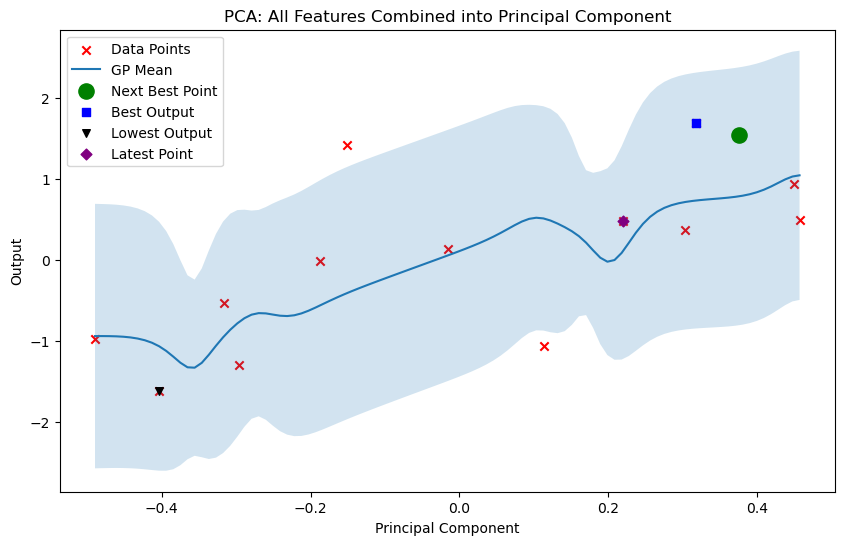

Next best point (2D): [0.73405915 0.85413915]
Predicted value at next best point: 1.541501466397780
Best output point: [0.65474086 0.85411448], Value: 1.690643012087511
Lowest output point: [0.10656553 0.38332246], Value: -1.619896549708239
Latest point: [0.71443004 0.64778986], Value: 0.474252243143039


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C

# Reduce to 1D using PCA
pca = PCA(n_components=1)
t_data = pca.fit_transform(x_final).ravel()
t_next = pca.transform(next_point.reshape(1, -1)).item()

# Define grid along PCA component
t_values = np.linspace(t_data.min(), t_data.max(), 100)
X_plot = pca.inverse_transform(t_values.reshape(-1, 1))


# Fit GP model
gp = hebo._fit_gp()  

# Get predictions
mean_pred, std_pred = gp.predict(X_plot, return_std=True)

# Find the best, lowest, and latest points
best_idx = np.argmax(y_final)  # Highest output
low_idx = np.argmin(y_final)   # Lowest output
latest_idx = -1                # Last added point

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(t_data, y_final, color='red', marker='x', label='Data Points')
plt.plot(t_values, mean_pred, label='GP Mean')
plt.fill_between(t_values, mean_pred - 1.96 * std_pred, mean_pred + 1.96 * std_pred, alpha=0.2)

# Plot next best point
plt.scatter(t_next, gp.predict(next_point.reshape(1, -1))[0], color='green', s=120, marker='o', label='Next Best Point')

# Highlight special points
plt.scatter(t_data[best_idx], y_final[best_idx], color='blue', s=30, marker='s', label='Best Output')   # Best
plt.scatter(t_data[low_idx], y_final[low_idx], color='black', s=30, marker='v', label='Lowest Output')   # Lowest
plt.scatter(t_data[latest_idx], y_final[latest_idx], color='purple', s=30, marker='D', label='Latest Point')  # Latest

plt.title('PCA: All Features Combined into Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Output')
plt.legend()
plt.show()
# Print key points
print("Next best point (2D):", next_point)
print(f"Predicted value at next best point: {gp.predict(next_point.reshape(1, -1))[0]:.15f}")

# Ensure all values are scalars before formatting
print(f"Best output point: {x_final[best_idx]}, Value: {y_final[best_idx].item():.15f}")
print(f"Lowest output point: {x_final[low_idx]}, Value: {y_final[low_idx].item():.15f}")
print(f"Latest point: {x_final[latest_idx]}, Value: {y_final[latest_idx].item():.15f}")



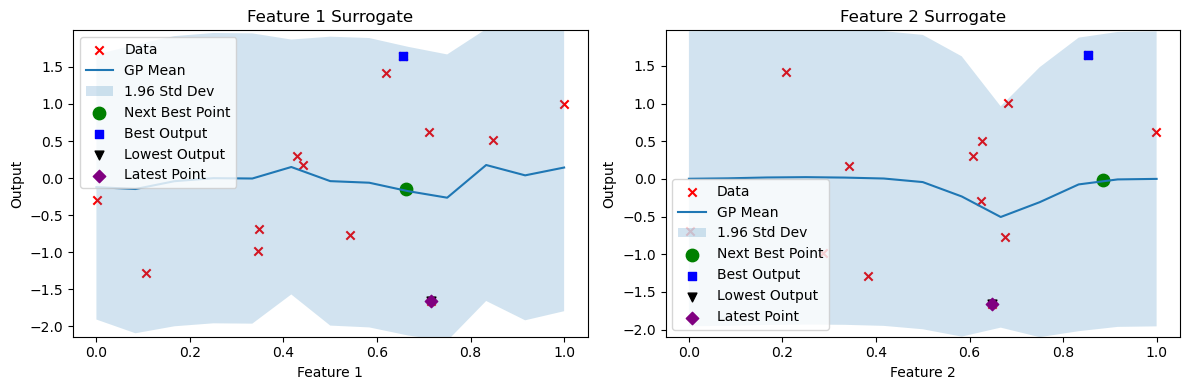

Best output point: [0.6547408562374539, 0.8541144765549031], Value: 1.649693352016169
Lowest output point: [0.7144300389396272, 0.6477898626621443], Value: -1.657837297927775
Latest point: [0.7144300389396272, 0.6477898626621443], Value: -1.657837297927775


In [64]:


import numpy as np
import matplotlib.pyplot as plt

def plot_gp_slices_clamped(hebo, f1_inp, f1_out, beta=1.96, n_points=100, kernel=None):
    """
    Plots 1D slices of the Gaussian Process model learned by HEBO.
    Each plot represents how the function behaves for a single feature while 
    holding other features constant at their mean values.
    """
    
    # Fit the GP model from HEBO
    gp = hebo._fit_gp(kernel=kernel)

    # Get next best point from HEBO
    next_point = hebo.suggest_next_point().flatten()

    # Means of other features
    means_other_features = np.mean(f1_inp, axis=0)

    # Full-dimensional prediction of the next point
    next_mean, next_std = gp.predict(next_point.reshape(1, -1), return_std=True)
    n_features = f1_inp.shape[1]

    # Find key points: Best, Lowest, and Latest
    best_idx = np.argmax(f1_out)   # Highest output
    low_idx = np.argmin(f1_out)    # Lowest output
    latest_idx = -1                # Last added point

    # Determine subplot grid
    n_cols = 2 if n_features > 1 else 1
    n_rows = int(np.ceil(n_features / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = np.atleast_1d(axes)  # Ensure it's always an array

    for i in range(n_features):
        ax = axes[i]

        # Build 1D grid for feature i
        grid = np.linspace(0, 1, n_points)
        X_plot = np.tile(means_other_features, (n_points, 1))
        X_plot[:, i] = grid

        # Predict on the grid
        mean_pred, std_pred = gp.predict(X_plot, return_std=True)

        # Observed data for this feature
        y_data = f1_out
        x_feat = f1_inp[:, i]

        # Posterior confidence band
        y_pred_lower = mean_pred - beta * std_pred
        y_pred_upper = mean_pred + beta * std_pred

        # Next best point on this feature slice
        X_next = means_other_features.copy()
        X_next[i] = next_point[i]
        y_next_dim = gp.predict(X_next.reshape(1, -1))[0]

        # Collect values for robust percentile-based y-axis clamping
       # Ensure y_data is 1D before concatenation
        y_all = np.concatenate([y_data.ravel(), y_pred_lower, y_pred_upper, [y_next_dim]])

        y_low, y_high = np.percentile(y_all, [2, 95])  # Clamping y-limits

        # Plot observed data points
        ax.scatter(x_feat, y_data, color='red', marker='x', label='Data')

        # Plot posterior mean prediction
        ax.plot(grid, mean_pred, label='GP Mean')

        # Plot confidence band
        ax.fill_between(grid, y_pred_lower, y_pred_upper, alpha=0.2, label=f'{beta} Std Dev')

        # Mark next best point
        ax.scatter(next_point[i], y_next_dim, color='green', s=80, marker='o', label='Next Best Point')

        # Mark best, lowest, and latest points
        ax.scatter(f1_inp[best_idx, i], f1_out[best_idx], color='blue', s=40, marker='s', label='Best Output')
        ax.scatter(f1_inp[low_idx, i], f1_out[low_idx], color='black', s=40, marker='v', label='Lowest Output')
        ax.scatter(f1_inp[latest_idx, i], f1_out[latest_idx], color='purple', s=40, marker='D', label='Latest Point')

        ax.set_title(f'Feature {i+1} Surrogate')
        ax.set_xlabel(f'Feature {i+1}')
        ax.set_ylabel('Output')
        ax.legend()
        ax.set_ylim([y_low, y_high])  # Apply clamping

    # Hide any extra subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print next best point details
    print(f"Best output point: {f1_inp[best_idx].tolist()}, Value: {f1_out[best_idx].item():.15f}")
    print(f"Lowest output point: {f1_inp[low_idx].tolist()}, Value: {f1_out[low_idx].item():.15f}")
    print(f"Latest point: {f1_inp[latest_idx].tolist()}, Value: {f1_out[latest_idx].item():.15f}")


# ✅ **Now call the function with HEBO**
plot_gp_slices_clamped(hebo, x_final, y_final, beta=1.96, n_points=13)


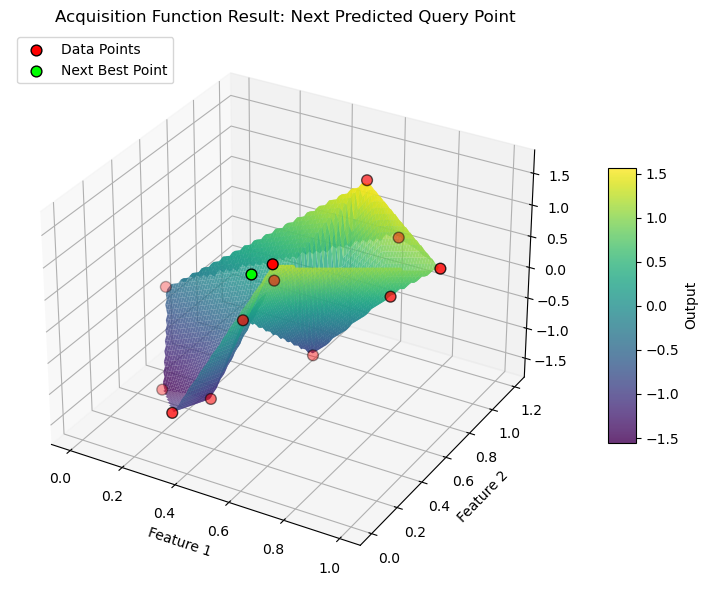

Next Best Point (WPI): at (x1=0.644153, x2=0.000833)


In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D projection

fig = plt.figure(figsize=(10, 6), facecolor='white')
ax = fig.add_subplot(111, projection='3d')

# Surface with fine resolution and smoother appearance
surf = ax.plot_surface(
    grid_x, grid_y, grid_z,
    cmap='viridis', alpha=0.8, edgecolor='none', rcount=100, ccount=100
)

# Colorbar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Output")

# Scatter points
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
#ax.scatter(max_x, max_y, max_z, color='orange', edgecolor='black', s=60, label="Maximum Point")
#ax.scatter(min_x, min_y, min_z, color='blue', edgecolor='black', s=60, label="Minimum Point")
ax.scatter(next_point[0], next_point[1], next_z, color='lime', edgecolor='black', s=60, label="Next Best Point")

# Labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
# ax.set_zlabel("Output")
ax.set_title("Acquisition Function Result: Next Predicted Query Point", loc="center")



# Custom viewing angle and legend~
ax.view_init(elev=30, azim=-60)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()
print(f"Next Best Point (WPI): at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f})")

